# Plot Figures 2-6

This notebook consolidates all plotting code for Figures 2, 3, 4, 5b, 5c, and 5d.

Data is loaded from `code_v2/processed_data/`:
- Figures 2-3: `fig23/` folder
- Figure 4: `fig4/` folder  
- Figures 5b-5c: `fig5/`, `fig5b/`, or `fig5c/` folders


## Imports and Setup


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Add common directory to path for data loader
common_path = Path().resolve().parent / 'common_scripts'
if str(common_path) not in sys.path:
    sys.path.insert(0, str(common_path))

# Import new data loader
from data_loader import load_figure_data, extract_shuttling_parameters, extract_two_point_data, extract_stationary_parameters



# Import correlation functions for spatial fit calculation
import correlation_fun

# Paths to data directories
processed_data_path = Path().resolve().parent / 'processed_data'
figures_path = Path().resolve().parent / 'figures'
figures_path.mkdir(exist_ok=True)


print(f"Processed data path: {processed_data_path}")
print(f"Figures path: {figures_path}")


Processed data path: /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/processed_data
Figures path: /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/figures


## Load Data for Figures 2-4

Load data from `code_v2/processed_data/`:
- Figures 2-3: from `fig23/` folder
- Figure 4: from `fig4/` folder


In [3]:
# Load data from new structure in code_v2/processed_data

# ============================================================================
# Load Figures 2-3 data (two-point correlation) from fig23/
# ============================================================================
fig23_path = processed_data_path / 'fig23'

# Load high field data (75mV)
with open(fig23_path / 'fig23_high_75mV.pkl', 'rb') as f:
    fig1_high_data = pickle.load(f)
# The data structure is {"chi1": [...], "chi12": [...]}
# For figure 2, we need chi1 data
if isinstance(fig1_high_data, dict) and "chi1" in fig1_high_data:
    params_high = {"params": fig1_high_data["chi1"]}
else:
    params_high = {"params": fig1_high_data}

# Load low field data
with open(fig23_path / 'fig23_low.pkl', 'rb') as f:
    fig1_low_data = pickle.load(f)
# For figure 2, we need chi1 data
if isinstance(fig1_low_data, dict) and "chi1" in fig1_low_data:
    params_low = {"params": fig1_low_data["chi1"]}
else:
    params_low = {"params": fig1_low_data}

# Extract two-point correlation data for figure 3
# The data structure should have chi1 and chi12
data = {}
# Initialize data structure for both fields upfront
for field in ["high", "low"]:
    data[field] = {"two_point": {}, "shuttle": {}}

for field in ["high", "low"]:
    if field == "high":
        two_point_data = fig1_high_data
    else:
        two_point_data = fig1_low_data
    
    # Extract chi1 and chi12 data
    # Check if data is in the expected format
    if isinstance(two_point_data, list):
        # If it's a list, extract directly without skipping first point
        # Extract chi1 (all points)
        distances_chi1 = np.array([point['x'] for point in two_point_data])
        T2_times_chi1 = np.array([point['T2'] for point in two_point_data])
        T2_errors_chi1 = np.array([point.get('dT', 0) for point in two_point_data])
        exponents_chi1 = np.array([point['n'] for point in two_point_data])
        exponent_errors_chi1 = np.array([point.get('dn', 0) for point in two_point_data])
        frequencies_chi1 = np.array([point.get('freq', 0) for point in two_point_data])
        
        sort_idx_chi1 = np.argsort(distances_chi1)
        data_2point = {
            'distances': distances_chi1[sort_idx_chi1],
            'T2_times': T2_times_chi1[sort_idx_chi1],
            'T2_errors': T2_errors_chi1[sort_idx_chi1],
            'exponents': exponents_chi1[sort_idx_chi1],
            'exponent_errors': exponent_errors_chi1[sort_idx_chi1],
            'frequencies': frequencies_chi1[sort_idx_chi1],
            'T12eff': np.array([]),
            'alpha12eff': np.array([]),
            'rnm': np.array([]),
            'rnm_errors': np.array([])
        }
        
        # Extract chi12 (keep ALL points, don't skip first)
        distances_chi12 = np.array([point['x'] for point in two_point_data])
        T2_times_chi12 = np.array([point['T2'] for point in two_point_data])
        T2_errors_chi12 = np.array([point.get('dT', 0) for point in two_point_data])
        exponents_chi12 = np.array([point['n'] for point in two_point_data])
        exponent_errors_chi12 = np.array([point.get('dn', 0) for point in two_point_data])
        frequencies_chi12 = np.array([point.get('freq', 0) for point in two_point_data])
        T12eff_chi12 = np.array([point.get('T12eff', 0) for point in two_point_data])
        alpha12eff_chi12 = np.array([point.get('alpha12eff', 0) for point in two_point_data])
        rnm_chi12 = np.array([point.get('rnm', 0) for point in two_point_data])
        rnm_errors_chi12 = np.array([point.get('rnm_err', 0) for point in two_point_data])
        
        # NOTE: We keep ALL points for chi12 (don't skip first like extractor does)
        sort_idx_chi12 = np.argsort(distances_chi12)
        data_2point_chi12 = {
            'distances': distances_chi12[sort_idx_chi12],
            'T2_times': T2_times_chi12[sort_idx_chi12],
            'T2_errors': T2_errors_chi12[sort_idx_chi12],
            'exponents': exponents_chi12[sort_idx_chi12],
            'exponent_errors': exponent_errors_chi12[sort_idx_chi12],
            'frequencies': frequencies_chi12[sort_idx_chi12],
            'T12eff': T12eff_chi12[sort_idx_chi12],
            'alpha12eff': alpha12eff_chi12[sort_idx_chi12],
            'rnm': rnm_chi12[sort_idx_chi12],
            'rnm_errors': rnm_errors_chi12[sort_idx_chi12]
        }
    elif isinstance(two_point_data, dict):
        # If it's a dict, check for chi1/chi12 structure
        if "chi1" in two_point_data and "chi12" in two_point_data:
            # Use extractor for chi1
            data_2point = extract_two_point_data(
                {"two_point": {field: two_point_data}},
                field=field, chi_type="chi1"
            )
            # For chi12, extract directly to keep all points
            chi12_list = two_point_data["chi12"]
            if isinstance(chi12_list, list):
                distances_chi12 = np.array([point['x'] for point in chi12_list])
                T2_times_chi12 = np.array([point['T2'] for point in chi12_list])
                T2_errors_chi12 = np.array([point.get('dT', 0) for point in chi12_list])
                exponents_chi12 = np.array([point['n'] for point in chi12_list])
                exponent_errors_chi12 = np.array([point.get('dn', 0) for point in chi12_list])
                frequencies_chi12 = np.array([point.get('freq', 0) for point in chi12_list])
                T12eff_chi12 = np.array([point.get('T12eff', 0) for point in chi12_list])
                alpha12eff_chi12 = np.array([point.get('alpha12eff', 0) for point in chi12_list])
                rnm_chi12 = np.array([point.get('rnm', 0) for point in chi12_list])
                rnm_errors_chi12 = np.array([point.get('rnm_err', 0) for point in chi12_list])
                
                # Keep ALL points (don't skip first)
                sort_idx_chi12 = np.argsort(distances_chi12)
                data_2point_chi12 = {
                    'distances': distances_chi12[sort_idx_chi12],
                    'T2_times': T2_times_chi12[sort_idx_chi12],
                    'T2_errors': T2_errors_chi12[sort_idx_chi12],
                    'exponents': exponents_chi12[sort_idx_chi12],
                    'exponent_errors': exponent_errors_chi12[sort_idx_chi12],
                    'frequencies': frequencies_chi12[sort_idx_chi12],
                    'T12eff': T12eff_chi12[sort_idx_chi12],
                    'alpha12eff': alpha12eff_chi12[sort_idx_chi12],
                    'rnm': rnm_chi12[sort_idx_chi12],
                    'rnm_errors': rnm_errors_chi12[sort_idx_chi12]
                }
            else:
                # Fallback to extractor
                data_2point_chi12 = extract_two_point_data(
                    {"two_point": {field: two_point_data}},
                    field=field, chi_type="chi12"
                )
        else:
            # Assume it's chi1 data, use extractor
            data_2point = extract_two_point_data(
                {"two_point": {field: {"chi1": two_point_data, "chi12": two_point_data}}},
                field=field, chi_type="chi1"
            )
            data_2point_chi12 = extract_two_point_data(
                {"two_point": {field: {"chi1": two_point_data, "chi12": two_point_data}}},
                field=field, chi_type="chi12"
            )
    else:
        # Fallback: create empty structure
        data_2point = {"distances": [], "T2_times": [], "T2_errors": [], "exponents": [], 
                       "exponent_errors": [], "frequencies": [], "T12eff": [], 
                       "alpha12eff": [], "rnm": [], "rnm_errors": []}
        data_2point_chi12 = data_2point.copy()
    
    # Initialize field structure - always ensure both keys exist
    if field not in data:
        data[field] = {}
    if "two_point" not in data[field]:
        data[field]["two_point"] = {}
    if "shuttle" not in data[field]:
        data[field]["shuttle"] = {}
    
    data[field]["two_point"]["chi1"] = data_2point
    data[field]["two_point"]["chi12"] = data_2point_chi12

# ============================================================================
# Load Figure 4 data (shuttling) from fig4/
# ============================================================================
fig4_path = processed_data_path / 'fig4'

# Load shuttling data
with open(fig4_path / 'shuttling_high.pkl', 'rb') as f:
    shuttling_high_raw = pickle.load(f)
with open(fig4_path / 'shuttling_low.pkl', 'rb') as f:
    shuttling_low_raw = pickle.load(f)

# Extract shuttling parameters
# Create a temporary data structure for the extractor
temp_data = {
    'shuttling': {
        'high': shuttling_high_raw,
        'low': shuttling_low_raw
    }
}

for field in ["high", "low"]:
    data_shuttle = extract_shuttling_parameters(temp_data, field=field)
    data_shuttle_echo = extract_shuttling_parameters(temp_data, field=field, experiment="Echo")
    data_shuttle_cpmg3 = extract_shuttling_parameters(temp_data, field=field, experiment="CPMG-3")
    
    # Ensure field and shuttle structure exist (defensive programming)
    if field not in data:
        data[field] = {}
    if "shuttle" not in data[field]:
        data[field]["shuttle"] = {}
    if "two_point" not in data[field]:
        data[field]["two_point"] = {}
    
    data[field]["shuttle"]["Ramsey"] = data_shuttle
    data[field]["shuttle"]["Echo"] = data_shuttle_echo
    data[field]["shuttle"]["CPMG-3"] = data_shuttle_cpmg3

# Calculate spatial fit data for figure 4 (using already loaded two-point data)
def calculate_correlation_matrix(positions, correlation_length):
    """Calculate spatial correlation matrix: C_ij = exp(-|x_i - x_j|/ξ)"""
    n = len(positions)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            C[i, j] = np.exp(-abs(positions[i] - positions[j]) / correlation_length)
    return C

for field in ["high", "low"]:
    # Get two-point chi1 data (already loaded above)
    chi1_data = data[field]["two_point"]["chi1"]
    x_2point = chi1_data['distances'][1:]
    T2_2point = chi1_data['T2_times'][1:]
    alpha_2point = np.clip(chi1_data['exponents'][1:], 1, 2)
    
    # Correlation length (dx): 120 for high, 18 for low
    dx = 120 if field == 'high' else 15
    
    # Calculate fitted lines
    T2_est, alpha_est, x_est = [], [], []
    T2_uncorr, alpha_uncorr = [], []
    
    for N in range(2, min(len(x_2point), 30)):
        if N <= len(T2_2point) and N <= len(alpha_2point):
            # Correlated case
            C1 = calculate_correlation_matrix(x_2point[:N+1], dx)
            t_star, alpha_eff = correlation_fun.calculate_chi_with_background_corrected(
                T2_2point[:N+1], alpha_2point[:N+1], N, C1, 9999999, 2)
            T2_est.append(t_star)
            alpha_est.append(alpha_eff)
            x_est.append(x_2point[N-1] + (x_2point[2]-x_2point[1])/2 if N > 2 else x_2point[N-1])
            
    # Store results
    if "spatial" not in data[field]:
        data[field]["spatial"] = {}
    data[field]["spatial"] = {
        "alpha_est": alpha_est,
        "T2_est": T2_est,
        "x_est": x_est,
        "alpha_uncorr": alpha_uncorr,
        "T2_uncorr": T2_uncorr
    }

print("✓ Calculated spatial fit data")

# ============================================================================
# Load frequency data for figure 2
# ============================================================================
freq_file = processed_data_path / 'fig23' / 'freq_compare_data_for_plot.npz'
freq_data_raw = np.load(str(freq_file))
xl = freq_data_raw["t_fine_low"]
xh = freq_data_raw["x_highfield_raw"]
fl = freq_data_raw["freq_low_for_plot"]
fh = freq_data_raw["y_highfield_raw"]
freq_data = {
    "dist_high": xh,
    "freqs_high": fh[::-1],
    "dist_low": xl + 20,
    "freqs_low": fl
}

print("✓ Loaded all data for figures 2-4")


Experiment CPMG-3 not found in low field data
Available data structure: dict_keys(['high', 'low'])
✓ Calculated spatial fit data
✓ Loaded all data for figures 2-4


## Load Data for Figures 5b, 5c, and 5d

Load data from `code_v2/processed_data/fig5/`, `fig5b/`, or `fig5c/` folders.


In [4]:
# ============================================================================
# Load Figure 5b data (Floquet spectrum) from fig5b/ or fig5/
# ============================================================================
fig5b_path = processed_data_path / 'fig5b'
fig5_path = processed_data_path / 'fig5'

# Try fig5b first, then fig5
fig5b_file = fig5b_path / 'fig5b_floquet_spectrum.pkl'
if not fig5b_file.exists():
    fig5b_file = fig5_path / 'fig5b_floquet_spectrum.pkl'

if fig5b_file.exists():
    with open(fig5b_file, 'rb') as f:
        floquet_data = pickle.load(f)
    data_2d = floquet_data['data_2d']
    x_axis = floquet_data['x_axis']
    cv_freqs = floquet_data['cv_freqs']
    print("✓ Loaded figure 5b data")
else:
    print("Warning: Figure 5b data not found. You may need to generate it from fig5b_data_gen.ipynb")
    data_2d = None
    x_axis = None
    cv_freqs = None

# ============================================================================
# Load Figure 5c data (Driven coherence) from fig5c/ or fig5/
# ============================================================================
fig5c_path = processed_data_path / 'fig5c'

# Try fig5c first, then fig5
fig5c_file = fig5c_path / 'fig5c_driven_coherence.pkl'
if not fig5c_file.exists():
    fig5c_file = fig5_path / 'fig5c_driven_coherence.pkl'

if fig5c_file.exists():
    with open(fig5c_file, 'rb') as f:
        fig5c_data = pickle.load(f)
    # Extract high field data
    all_frequencies = fig5c_data['high_field']['frequencies']
    all_T2_values = fig5c_data['high_field']['T2_values']
    all_cv_stops = fig5c_data['high_field']['cv_stops']
    all_dT2_values = fig5c_data['high_field']['T2_errors']
    
    # Extract low field data  
    lowfield_f = np.array([f * 1000 for f in fig5c_data['low_field']['frequencies']])  # Convert to MHz
    lowfield_tau = np.array(fig5c_data['low_field']['T2_values'])
    lowfield_f_err = np.array([e * 1000 for e in fig5c_data['low_field']['f_errors']])  # Convert to MHz
    lowfield_tau_err = np.array(fig5c_data['low_field']['T2_errors'])
    
    cv_stops = fig5c_data.get('cv_stops', [0, 5, 10, 15, 19])
    print("✓ Loaded figure 5c data")
else:
    print("Warning: Figure 5c data not found. You may need to generate it from fig5c_data_gen.ipynb")
    all_frequencies = []
    all_T2_values = []
    all_cv_stops = []
    all_dT2_values = []
    lowfield_f = np.array([])
    lowfield_tau = np.array([])
    lowfield_f_err = np.array([])
    lowfield_tau_err = np.array([])
    cv_stops = [0, 5, 10, 15, 19]


✓ Loaded figure 5b data
✓ Loaded figure 5c data


## Figure 2: Stationary Coherence (T2 and Exponent)


4.419742266471774
8.531267541352543


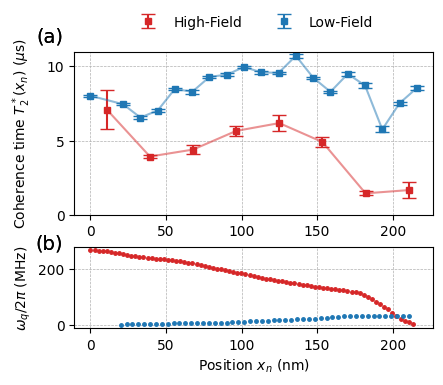

In [5]:
def plot_t2_and_exponent(
    data_high_field,
    data_low_field,
    freqs_data,
    x_label="Shuttling Distance (µm)",
    plot_low=True
):
    """
    Generates a 3-panel plot for T2, frequency, and exponent data.
    Matches the plotting style from Plot_fig2_fig3_fig4.ipynb
    """
    # Create a figure with a custom gridspec
    fig = plt.figure(figsize=(4.5, 4))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.5])
    axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
    plt.subplots_adjust(hspace=0.3)

    if plot_low:
        all_data = {
            "High-Field": {"data": data_high_field, "color": "tab:red"},
            "Low-Field": {"data": data_low_field, "color": "tab:blue"},
        }
    else:
        all_data = {
            "High-Field": {"data": data_high_field, "color": "tab:red"},
        }

    for label, props in all_data.items():
        params = props["data"]["params"]
        color = props["color"]

        # Process Data
        try:
            x_data = np.array([p["d"] for p in params])
        except:
            x_data = np.array([p["x"] for p in params])

        
        exponent = np.array([p["n"] for p in params])
        exponent_err = np.array([p["dn"] for p in params])
        T2s = np.array([p["T2"] for p in params]) * 1e-3
        T2s_err = np.array([p["dT"] for p in params]) * 1e-3

        order_ind = np.argsort(x_data)
        x_data = x_data[order_ind]
        exponent = exponent[order_ind]
        exponent_err = exponent_err[order_ind]
        T2s = T2s[order_ind]
        T2s_err = T2s_err[order_ind]

        if label == "High-Field":
            x_data = np.array(x_data)
        
        ax_t2, ax_freq = axes

        # Frequency Plot
        ax_freq.errorbar([], [], fmt='-s', capsize=3, ms=4, color=color, label=label)  # dummy plot for legend
        ax_freq.set_ylabel(r"$\omega_q/2\pi$ (MHz)")
        ax_freq.set_xlabel("")

        downsample_hf = 50
        downsample_lf = 20
        ms = 5
        if label == "High-Field":
            ax_freq.plot(freqs_data["dist_high"][::downsample_hf], freqs_data["freqs_high"][::downsample_hf], 
                        '.', ms=ms, color=color)
        else:
            ax_freq.plot(freqs_data["dist_low"][::downsample_lf], freqs_data["freqs_low"][::downsample_lf], 
                        '.', ms=ms, color=color)

        ax_freq.grid(True, linestyle='--', linewidth=0.5)

        # T2 Plot
        if label == "High-Field":
            T2s = T2s[1:]
            T2s_err = T2s_err[1:]
            x_data = x_data[1:]
            exponent = exponent[1:]
            exponent_err = exponent_err[1:]
        print(np.average(T2s))
        ax_t2.errorbar(x_data, T2s, yerr=T2s_err, fmt='s', capsize=5, ms=4, color=color, label=label)
        ax_t2.plot(x_data, T2s, '-', ms=ms, color=color, alpha=0.5)
        ax_t2.set_ylabel(r"Coherence time $T_2^*(x_n)$ ($\mu$s)")
        ax_t2.grid(True, linestyle='--', linewidth=0.5)
        ax_t2.set_ylim(bottom=0, top=11)
        ax_t2.set_yticks([0, 5, 10])


        # Add subplot labels
        ax_freq.text(-0.03, 1.15, "(b)", transform=ax_freq.transAxes, fontsize=14, va='top', ha='right')
        ax_t2.text(-0.03, 1.15, "(a)", transform=ax_t2.transAxes, fontsize=14, va='top', ha='right')

        ax_freq.set_xlim(ax_t2.get_xlim())

    ax_t2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False)
   
    plt.xlabel(x_label)
    plt.tight_layout(h_pad=-0.4)
    fig.align_ylabels(axes)
    
    return fig, axes

# Generate Figure 2
fig2, axes2 = plot_t2_and_exponent(params_high, params_low, freq_data, x_label=r"Position $x_n$ (nm)", plot_low=True)
plt.savefig(figures_path / "fig2_stationary.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Figure 3: Two-Point Correlation


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_90616/2064906171.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


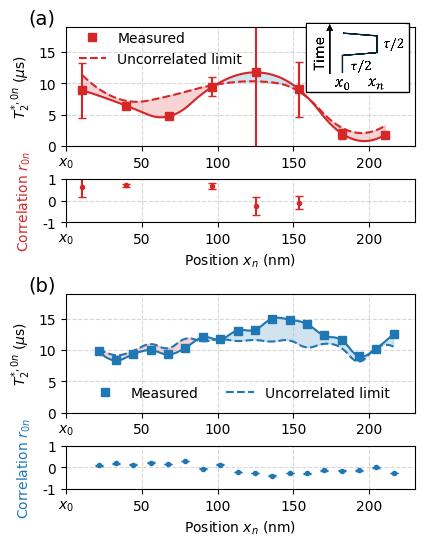

In [6]:
# FIGURE 3: Two-point correlation
# Matches the plotting style from Plot_fig2_fig3_fig4.ipynb
fig3 = plt.figure(figsize=(4.5, 6))
gs = fig3.add_gridspec(5, 1, height_ratios=[2.2, 0.8, 0.1, 2.2, 0.8], hspace=0.5)

# Create 4 axes: (a) red main, (b) red r_{0n}, (c) blue main, (d) blue r_{0n}
ax3 = [fig3.add_subplot(gs[i]) for i in range(2)]
ax3.append(fig3.add_subplot(gs[3]))
ax3.append(fig3.add_subplot(gs[4]))

colors = ["tab:red", "tab:blue"]

for nrow, field in enumerate(["high", "low"]):
    x1 = data[field]["two_point"]["chi12"]["distances"]
    ymeasured = data[field]["two_point"]["chi12"]["T2_times"]/1e3
    yeff = data[field]["two_point"]["chi12"]["T12eff"]/1e3
    # Interpolate ymeasured and yeff as functions of x1
    f12_measured = interp1d(x1, ymeasured, kind='quadratic', fill_value='extrapolate')
    f12_eff = interp1d(x1, yeff, kind='quadratic', fill_value='extrapolate')
    
    x_interp = np.linspace(np.min(x1), np.max(x1), 100)
    ymeasured_interp = f12_measured(x_interp)
    yeff_interp = f12_eff(x_interp)
    
    # Main plot
    ax_main = ax3[nrow * 2]
    ax_r = ax3[nrow * 2 + 1]
    
    # Plot with errorbars and interpolated lines
    line_measured = ax_main.errorbar(
        x1, ymeasured, yerr=data[field]["two_point"]["chi12"]["T2_errors"]/1e3,
        fmt='s', capsize=3, color=colors[nrow], label='Measured'
    )
    line_uncorr, = ax_main.plot(
        x_interp, yeff_interp, "--", color=colors[nrow], label='Uncorrelated limit'
    )
    ax_main.plot(x_interp, ymeasured_interp, "-", color=colors[nrow])
    
    # Fill between curves
    ax_main.fill_between(x_interp, yeff_interp, ymeasured_interp, 
                          where=(yeff_interp > ymeasured_interp), color='tab:red', alpha=0.2)
    ax_main.fill_between(x_interp, yeff_interp, ymeasured_interp, 
                          where=(yeff_interp < ymeasured_interp), color='tab:blue', alpha=0.2)
    
    if nrow == 0:
        ax_main.legend([line_measured.lines[0], line_uncorr], 
                    ['Measured', 'Uncorrelated limit'],
                    ncol=1, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.07))
        ax_main.set_yticks([0, 5, 10, 15])
        ax_main.set_yticklabels([0, 5, 10, 15])
    else:
        ax_main.legend([line_measured.lines[0], line_uncorr], 
                    ['Measured', 'Uncorrelated limit'],
                     frameon=False, loc='lower center', ncol=2)
        ax_main.set_yticks([0, 5, 10, 15])
        ax_main.set_yticklabels([0, 5, 10, 15])
    
    ax_main.set_ylim(0, 19)
    ax_main.set_ylabel(r"$T_{2}^{*,0n}$ ($\mu$s)")
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.set_xticks([0, 50, 100, 150, 200])
    ax_main.set_xticklabels([r"$x_0$", 50, 100, 150, 200])
    ax_main.set_xlim(0, 230)
    
    # Panel labels
    main_labels = ['(a)', '(b)']
    ax_main.text(-0.03, 1.15, main_labels[nrow], transform=ax_main.transAxes, 
                  fontsize=14, va='top', ha='right')
    
    # r_{0n} plot
    r0n = data[field]["two_point"]["chi12"]["rnm"]
    r0n_err = data[field]["two_point"]["chi12"]["rnm_errors"]
    ax_r.errorbar(x1, r0n[:], yerr=r0n_err[:], fmt='.', capsize=3, color=colors[nrow])
    ax_r.set_ylabel(r"Correlation $r_{0n}$", color=colors[nrow])
    ax_r.set_ylim(-1, 1)
    ax_r.set_yticks([-1, 0, 1])
    ax_r.set_yticklabels([-1, 0, 1])
    ax_r.set_xlim([0, 230])
    ax_r.set_xticks([0, 50, 100, 150, 200])
    ax_r.set_xticklabels([r"$x_0$", 50, 100, 150, 200])
    ax_r.yaxis.label.set_color(colors[nrow])
    ax_r.yaxis.set_label_position("left")
    ax_r.yaxis.tick_left()
    ax_r.grid(True, linestyle='--', alpha=0.5)
    ax_r.set_xlabel("Position $x_n$ (nm)")

fig3.align_ylabels(ax3)

# Load and add cartoon for figure 3
cartoon_path = figures_path / 'fig3_cartoon.png'
if cartoon_path.exists():
    img = plt.imread(str(cartoon_path))
    # Crop the image
    height, width = img.shape[:2]
    crop_ymin = int(0.10 * height)
    crop_ymax = int(0.90 * height)
    crop_xmin = int(0.12 * width)
    crop_xmax = int(0.98 * width)
    img_cropped = img[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
    
    imagebox = OffsetImage(img_cropped, zoom=0.18)
    ab = AnnotationBbox(imagebox, (0.95, 0.87), xycoords='figure fraction',
                        frameon=True, box_alignment=(1.2,1), pad=0.1)
    fig3.add_artist(ab)
else:
    print(f"Warning: Cartoon not found at {cartoon_path}")

plt.tight_layout()
plt.savefig(figures_path / "fig3_two_point_correlation.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Figure 4: Shuttling T2 Times


In [7]:
np.max(data["low"]["shuttle"]["Ramsey"]["T2_errors"])

1167.3641053794304

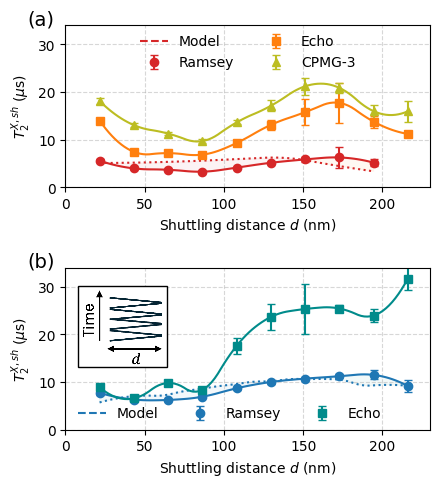

In [8]:
# FIGURE 4: Shuttling T2 times
# Matches the plotting style from Plot_fig2_fig3_fig4.ipynb
fig4, ax4 = plt.subplots(2, 1, figsize=(4.5, 5), sharex=False)
plt.subplots_adjust(hspace=0.1)

dark_pink = "#d72660"
colors = [["tab:red", "tab:orange", "tab:olive"], ["tab:blue", "darkcyan"]]

for nrow, field in enumerate(["high", "low"]):
    x1 = data[field]["shuttle"]["Ramsey"]["distances"]
    x2 = data[field]["shuttle"]["Echo"]["distances"]
    y1measured = data[field]["shuttle"]["Ramsey"]["T2_times"] / 1e3
    y2measured = data[field]["shuttle"]["Echo"]["T2_times"] / 1e3
    
    try:
        y3measured = data[field]["shuttle"]["CPMG-3"]["T2_times"] / 1e3
    except:
        y3measured = None

    # Interpolate
    f2_measured = interp1d(data[field]["shuttle"]["Echo"]["distances"], 
                          y2measured, kind='quadratic', fill_value='extrapolate')
    if y3measured is not None:
        f3_measured = interp1d(data[field]["shuttle"]["CPMG-3"]["distances"], 
                              y3measured, kind='quadratic', fill_value='extrapolate')

    y1eff = np.array(data[field]["spatial"]["T2_est"]) / 1e3
    x1eff = np.array(data[field]["spatial"]["x_est"])

    f1_measured = interp1d(x1, y1measured, kind='quadratic', fill_value='extrapolate')
    f1_eff = interp1d(x1eff, y1eff, kind='quadratic', fill_value='extrapolate')

    x_interp = np.linspace(np.min(x1), np.max(x1), 100)
    y1measured_interp = f1_measured(x_interp)
    y1eff_interp = f1_eff(x_interp)

    # Plot Ramsey with model
    ax4[nrow].plot(x_interp, y1measured_interp, "-", color=colors[nrow][0])
    ax4[nrow].plot(x_interp, y1eff_interp, ":", color=colors[nrow][0])

    ax4[nrow].fill_between(x_interp, y1eff_interp, y1measured_interp, 
                          where=(y1eff_interp > y1measured_interp), 
                          color=colors[nrow][0], alpha=0.05)
    ax4[nrow].fill_between(x_interp, y1eff_interp, y1measured_interp, 
                          where=(y1eff_interp < y1measured_interp), 
                          color=colors[nrow][1], alpha=0.05)

    ax4[nrow].errorbar(x1, y1measured, 
                      yerr=data[field]["shuttle"]["Ramsey"]["T2_errors"] / 1e3, 
                      fmt='o', capsize=3, color=colors[nrow][0], label='Ramsey')
    ax4[nrow].errorbar(data[field]["shuttle"]["Echo"]["distances"], y2measured, 
                      yerr=data[field]["shuttle"]["Echo"]["T2_errors"] / 1e3, 
                      fmt='s', capsize=3, color=colors[nrow][1], label='Echo')

    if y3measured is not None:
        ax4[nrow].errorbar(data[field]["shuttle"]["CPMG-3"]["distances"], y3measured, 
                          yerr=data[field]["shuttle"]["CPMG-3"]["T2_errors"] / 1e3, 
                          fmt='^', capsize=3, color=colors[nrow][2], label='CPMG-3')

    # Plot Echo and CPMG-3 interpolations
    x_interp2 = np.linspace(np.min(data[field]["shuttle"]["Echo"]["distances"]), 
                           np.max(data[field]["shuttle"]["Echo"]["distances"]), 100)
    y2measured_interp = f2_measured(x_interp2)
    ax4[nrow].plot(x_interp2, y2measured_interp, "-", color=colors[nrow][1])
    
    if y3measured is not None:
        y3measured_interp = f3_measured(x_interp2)
        ax4[nrow].plot(x_interp2, y3measured_interp, "-", color=colors[nrow][2])

    # Set limits and labels
    ax4[nrow].set_ylim(0, 34)
    ax4[nrow].set_xlabel("Shuttling distance $d$ (nm)")
    if nrow == 0:
        ax4[nrow].set_ylabel(r"$T_{2}^{X,sh}$ ($\mu$s)")
    else:
        ax4[nrow].set_ylabel(r"$T_{2}^{X,sh}$ ($\mu$s)")

    ax4[nrow].plot([], [], linestyle='--', color=colors[nrow][0], label='Model')

    # Legend
    if nrow == 0:
        ax4[nrow].legend(ncol=2, frameon=False, loc='upper center',  bbox_to_anchor=(0.5, 1.02))
    else:
        ax4[nrow].legend(ncol=3, frameon=False, loc='lower left', bbox_to_anchor=(0, -0.02))

    # Grid and ticks
    ax4[nrow].grid(True, linestyle='--', alpha=0.5)
    ax4[nrow].set_xticks([0, 50, 100, 150, 200])
    ax4[nrow].set_xticklabels([0, 50, 100, 150, 200], fontsize=10)
    ax4[nrow].set_xlim(0, 230)
    
    # Panel label
    labels = ['(a)', '(b)']
    ax4[nrow].text(-0.03, 1.1, labels[nrow], transform=ax4[nrow].transAxes, 
                  fontsize=14, va='top', ha='right')

fig4.align_ylabels(ax4)

# Load and add cartoon for figure 4
cartoon_path = figures_path / 'Fig4_cartoon.png'
if cartoon_path.exists():
    img = plt.imread(str(cartoon_path))
    height, width = img.shape[:2]
    crop_ymin = int(0.03 * height)
    crop_ymax = int(0.9 * height)
    crop_xmin = int(0.05 * width)
    crop_xmax = int(0.98 * width)
    img_cropped = img[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
    imagebox = OffsetImage(img_cropped, zoom=0.18)
    ab = AnnotationBbox(imagebox, (0.37, 0.45), xycoords='figure fraction',
                        frameon=True, box_alignment=(1,1.3), pad=0.0)
    fig4.add_artist(ab)

plt.tight_layout()
plt.savefig(figures_path / "fig4_shuttling_T2.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Figure 5b: Floquet Spectrum


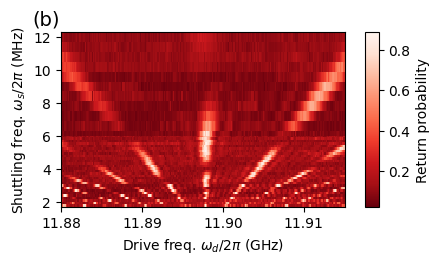

In [10]:
# FIGURE 5b: Floquet spectrum
# Matches the plotting style from dressed_gen_fig5b.ipynb
if data_2d is not None:
    fig5b, ax5b = plt.subplots(figsize=(4.5, 2.8))
    
    # Use custom colormap
    pcm = ax5b.pcolormesh(x_axis*1e-9, cv_freqs[:-1], data_2d, shading='auto', cmap="Reds_r", rasterized=True)
    
    # Add colorbar
    divider = make_axes_locatable(ax5b)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(pcm, cax=cax, orientation='vertical')
    cbar.set_label('Return probability')
    cax.xaxis.set_ticks_position('top')
    cax.xaxis.set_label_position('top')
    
    ax5b.set_xlabel(r'Drive freq. $\omega_d/2\pi$ (GHz)', fontsize=10)
    ax5b.set_ylabel(r'Shuttling freq. $\omega_s/2\pi$ (MHz)', fontsize=10)
    ax5b.text(-0.1, 1.13, r'(b)', transform=ax5b.transAxes, fontsize=14, va='top', ha='left')
    
    plt.tight_layout()
    plt.savefig(figures_path / "fig5_b.pdf", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping figure 5b - data not loaded")


## Figure 5c: Driven Coherence (T2 vs Rabi Frequency)


[10.17012116 12.24585127 13.806757   11.38512295 14.82239837 11.40359369
 11.08801714 11.16340625  8.56207724  8.96811088 11.10157661  9.10707611
  9.47471247  8.51072893]
[ 9.41728763 10.00287217  8.30002418  8.20158453  8.3569687   8.38804472
  9.49897907  7.37588703  7.37588703  6.91578155  7.65653317  6.5035873
  6.0791141   7.39413895  5.28486954]
[11.19325735  9.22485965  8.14062299  9.29726087  8.68134667 10.04784125
  7.99982155  9.51575449  8.45492512  7.27192813  7.96148033  7.5421708
  7.50063365  7.18417362  6.93235502  6.21049382  5.99487724  5.42022234
  5.8498738 ]
[4.38861902 4.43831597 4.62061983 4.15567142 4.4787233  3.92442759
 3.74689466 4.03323269 4.22847384 4.02750217 3.73903919 3.54684596
 3.48980739 3.44161465 3.59575379]


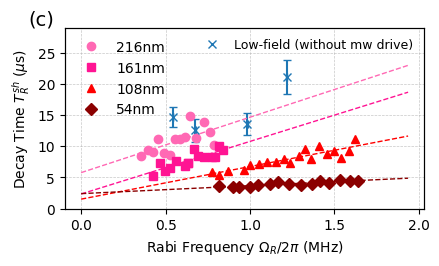

In [14]:
# FIGURE 5c: T2 vs Rabi Frequency
# Matches the plotting style from driven_gen_fig5cd.ipynb
if len(all_frequencies) > 0:
    plt.rcParams['font.size'] = 10
    fig5c, ax5c = plt.subplots(figsize=(4.5, 2.8))
    
    # Plot low field data
    ms = 6
    if len(lowfield_f) > 0:
        ax5c.errorbar(lowfield_f, lowfield_tau/1e3, 
                    xerr=lowfield_f_err, yerr=lowfield_tau_err/1e3,
                    fmt='x', color='tab:blue',
                    markersize=ms, capsize=3)
    
    # Define color palette for high field data
    red_colors = ['hotpink', 'deeppink', 'red', 'darkred']
    markers_list = ['o', 's', '^', 'D', 'v']
    zs = []
    zs_uncertainties = []
    
    # Plot high field data with fits
    for i, (cv_stop, marker) in enumerate(zip(cv_stops[:-1], markers_list[:-1])):
        mask = np.array(all_cv_stops) == cv_stop
        
        frequencies = np.array(all_frequencies)[mask] * 1000  # Convert GHz to MHz
        T2_values = np.array(all_T2_values)[mask]/1e3
        print(T2_values)
        color = red_colors[i % len(red_colors)]
        
        # Plot data points
        ax5c.plot(frequencies, T2_values, marker,
                color=color, markersize=ms,
                label=f'{int((20-cv_stop)*0.06*180)}nm')
        
        # Add linear fit if there are points
        if len(frequencies) > 0:
            z = np.polyfit(frequencies, T2_values, 1)
            p = np.poly1d(z)
            x_fit = np.linspace(0, max(np.array(all_frequencies) * 1000) * 1.1, 100)
            ax5c.plot(x_fit, p(x_fit), '--', color=color, linewidth=1)
            zs.append(z)
            
            # Calculate uncertainties for the gradient using scipy.stats.linregress
            slope, intercept, r_value, p_value, std_err = linregress(frequencies, T2_values)
            zs_uncertainties.append(std_err)
    
    # Apply styling
    ax5c.set_xlabel(r'Rabi Frequency $\Omega_R/2\pi$ (MHz)', fontsize=10)
    ax5c.set_ylabel(r'Decay Time $T_R^{sh}$ ($\mu$s)', fontsize=10)
    ax5c.set_ylim(0, 29)
    ax5c.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax5c.legend(frameon=False, ncol=1, loc="upper left")
    
    if len(lowfield_f) > 0:
        bx = ax5c.twinx()
        bx.set_yticks([])
        bx.plot([], [], 'x', color='tab:blue', label='Low-field (without mw drive)')
        bx.legend(ncol=1, frameon=False, loc='upper right', fontsize=9)
    
    ax5c.text(-0.1, 1.1, r'(c)', transform=ax5c.transAxes, fontsize=14, va='top', ha='left')
    
    plt.tight_layout()
    plt.savefig(figures_path / 'fig5_c.pdf', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping figure 5c - data not loaded")


## Figure 5d: Gradient Plot


[8.869170469695044, 8.414584750972761, 5.217407552096284, 1.2754046285307905]


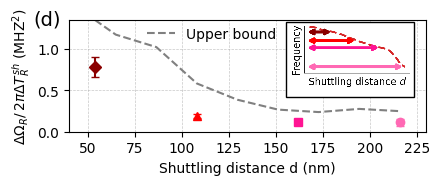

In [12]:
# FIGURE 5d: Gradient Plot
# Matches the plotting style from driven_gen_fig5cd.ipynb
# Calculate gradients from Figure 5c data (zs and zs_uncertainties calculated above)

from scipy.optimize import curve_fit



if 'zs' in locals() and len(zs) > 0:
    # Extract the Ramsey data for the model
    T2s_ramsey = np.array(data["high"]["shuttle"]["CPMG-3"]["T2_times"])  # in microseconds
    alphas_ramsey = np.array(data["high"]["shuttle"]["Echo"]["exponents"])
    distances_ramsey = np.array(data["high"]["shuttle"]["Echo"]["distances"])  # in nm
 
    # Calculate dg using the model from driven_gen_fig5cd.ipynb
    v = 10.8 # Velocity
    Ts = 2*distances_ramsey/v
    chis = (Ts/T2s_ramsey)**(1)*(1/Ts)**(2)

    # Create an interpolator function
    # Evaluation points (distances corresponding to cv_stops)
    # From driven_gen_fig5cd.ipynb: ds = [54,108,162,216][::-1] = [216, 162, 108, 54]
    # But we need to match cv_stops: [0, 5, 10, 15] -> distances: [216, 162, 108, 54]
    ds = [54, 108, 162, 216][::-1]  # Reverse to match cv_stops order
    x_new = np.array([54, 81, 108, 135, 161, 180])  # More points for interpolation
    
    # Extract gradients from zs (slopes of linear fits)
    gradients = [z[0] for z in zs]
    print(gradients)
    gradient_errors = np.array(zs_uncertainties)
    # Create the plot
    fig5d, ax5d = plt.subplots(figsize=(4.5, 2))
    ax5d.plot(distances_ramsey,np.array(chis)*1e6/2/np.pi, "--", color="gray", label = "Upper bound")

    red_colors = ['hotpink', 'deeppink', 'red', 'darkred']
    markers_list = ['o', 's', '^', 'D']
    
    # Plot fitted model curve
    #ax5d.plot(d_fit, y_fit, 'k-', linewidth=2, label=f'Fit: λ_c={lambda_c_fit:.1f} nm')

    ax5d.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.4, 1.05))
    
    # Plot gradient data
    for i, (grad, grad_err, marker) in enumerate(zip(gradients, gradient_errors, markers_list)):
        color = red_colors[i % len(red_colors)]
        distance = ds[i] if i < len(ds) else 0
        ax5d.errorbar(distance, 1/grad, yerr=grad_err/grad**2, fmt=marker, 
                     color=color, markersize=ms, capsize=3)
    
    ax5d.set_xlabel("Shuttling distance d (nm)", fontsize=10)
    ax5d.set_ylabel(r"$\Delta \Omega_{R}/\,2\pi\Delta T_{R}^{sh}$ (MHZ$^{2}$)", fontsize=10)
    ax5d.set_ylim(bottom=-0.2, top = 1.1)
    ax5d.set_xlim(left=30)
    ax5d.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax5d.text(-0.1, 1.1, r'(d)', transform=ax5d.transAxes, fontsize=14, va='top', ha='left')
    #ax5d.set_yscale("log")
    # Load and add cartoon for figure 5d
    cartoon_path = figures_path / 'cartoon_fig5.png'
    if cartoon_path.exists():
        img = plt.imread(str(cartoon_path))
        height, width = img.shape[:2]
        crop_ymin = int(0.10 * height)
        crop_ymax = int(0.93 * height)
        crop_xmin = int(0.06 * width)
        crop_xmax = int(0.94 * width)
        img_cropped = img[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
        imagebox = OffsetImage(img_cropped, zoom=0.2)
        ab = AnnotationBbox(imagebox, (0.90, 0.8), xycoords='figure fraction',
                    frameon=True, box_alignment=(0.95,1), pad=0.2)
        fig5d.add_artist(ab)
    plt.xlim(40,230)
    plt.ylim(0.0,1.35)
    plt.tight_layout()
    plt.savefig(figures_path / 'fig5_d.pdf', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping figure 5d - gradients not calculated (figure 5c data needed)")


## Figure 6: Overview Comparison


Debug: Checking shuttling distances:
  high field Ramsey distances: [ 21.6  43.2  64.8  86.4 108.  129.6 151.2 172.8 194.4]
    Index [2] = 64.8nm (currently labeled as 50nm)
    Index [6] = 151.2nm (currently labeled as 150nm)
  high field Echo distances: [ 21.6  43.2  64.8  86.4 108.  129.6 151.2 172.8 194.4 216. ]
    Index [2] = 64.8nm (currently labeled as 50nm)
    Index [6] = 151.2nm (currently labeled as 150nm)
  low field Ramsey distances: [ 21.6  43.2  64.8  86.4 108.  129.6 151.2 172.8 194.4 216. ]
    Index [2] = 64.8nm (currently labeled as 50nm)
    Index [6] = 151.2nm (currently labeled as 150nm)
  low field Echo distances: [ 21.6  43.2  64.8  86.4 108.  129.6 151.2 172.8 194.4 216. ]
    Index [2] = 64.8nm (currently labeled as 50nm)
    Index [6] = 151.2nm (currently labeled as 150nm)
✓ Loaded fig5_driven.pkl from processed_data/fig5/


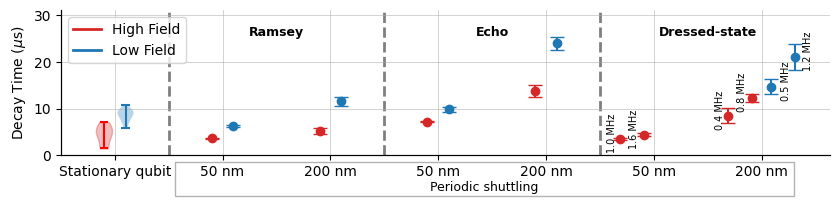

In [15]:
# FIGURE 6: Overview comparison
# Matches the plotting style from Plot_fig6.ipynb

# ============================================================================
# Extract stationary data
# ============================================================================
# Get stationary T2 times for low and high field
# Low field stationary data
T2_low_stat = np.array([p["T2"] for p in params_low["params"]])

# High field stationary data
T2_high_dense = np.array([p["T2"] for p in params_high["params"]])

T2_low_stat = T2_low_stat[1:]
T2_high_dense = T2_high_dense[1:]
# ============================================================================
# Extract shuttling data at specific distances
# ============================================================================
T2R = {field: {} for field in ["high", "low"]}
T2R_err = {field: {} for field in ["high", "low"]}

for field in ["high", "low"]:
    for experiment in ["Ramsey", "Echo"]:
        if experiment in data[field]["shuttle"] and data[field]["shuttle"][experiment] is not None:
            T2R[field][experiment] = np.array(data[field]["shuttle"][experiment]["T2_times"])
            T2R_err[field][experiment] = np.array(data[field]["shuttle"][experiment]["T2_errors"])

# Debug: Print distances to check if indices [2] and [6] are correct
print("\nDebug: Checking shuttling distances:")
for field in ["high", "low"]:
    if "Ramsey" in T2R[field] and len(T2R[field]["Ramsey"]) > 0:
        distances = data[field]["shuttle"]["Ramsey"]["distances"]
        print(f"  {field} field Ramsey distances: {distances}")
        if len(distances) > 2:
            print(f"    Index [2] = {distances[2]:.1f}nm (currently labeled as 50nm)")
        if len(distances) > 6:
            print(f"    Index [6] = {distances[6]:.1f}nm (currently labeled as 150nm)")
    if "Echo" in T2R[field] and len(T2R[field]["Echo"]) > 0:
        distances = data[field]["shuttle"]["Echo"]["distances"]
        print(f"  {field} field Echo distances: {distances}")
        if len(distances) > 2:
            print(f"    Index [2] = {distances[2]:.1f}nm (currently labeled as 50nm)")
        if len(distances) > 6:
            print(f"    Index [6] = {distances[6]:.1f}nm (currently labeled as 150nm)")

# ============================================================================
# Load driven experiment data
# ============================================================================
# Load from processed_data/fig5/fig5_driven.pkl
driven_data = [[], [], []]  # [hf_100, hf_200, lf_200]

fig5_driven_path = processed_data_path / 'fig5' / 'fig5_driven.pkl'

if fig5_driven_path.exists():
    try:
        with open(fig5_driven_path, 'rb') as f:
            driven_data_raw = pickle.load(f)
        
        # Convert to format expected by plotting code: [hf_100, hf_200, lf_200]
        # Each element is a list of tuples: (rabi_freq_MHz, T2_time_ns, T2_error_ns)
        # Data structure: {'high': {100: [...], 200: [...]}, 'low': {200: [...]}}
        if isinstance(driven_data_raw, dict):
            if 'high' in driven_data_raw and isinstance(driven_data_raw['high'], dict):
                if 100 in driven_data_raw['high']:
                    driven_data[0] = driven_data_raw['high'][100]  # High field 100nm
                if 200 in driven_data_raw['high']:
                    driven_data[1] = driven_data_raw['high'][200]  # High field 200nm
            if 'low' in driven_data_raw and isinstance(driven_data_raw['low'], dict):
                if 200 in driven_data_raw['low']:
                    driven_data[2] = driven_data_raw['low'][200]    # Low field 200nm
        print("✓ Loaded fig5_driven.pkl from processed_data/fig5/")
        
        # If low field data is empty, try to extract from fig5c_driven_coherence.pkl
        if len(driven_data[2]) == 0:
            fig5c_driven_path = processed_data_path / 'fig5' / 'fig5c_driven_coherence.pkl'
            if fig5c_driven_path.exists():
                try:
                    with open(fig5c_driven_path, 'rb') as f:
                        fig5c_data = pickle.load(f)
                    
                    # Extract low field data (200nm) - take first 2 points
                    if 'low_field' in fig5c_data:
                        low_freqs = fig5c_data['low_field'].get('frequencies', [])
                        low_T2s = fig5c_data['low_field'].get('T2_values', [])
                        low_dT2s = fig5c_data['low_field'].get('T2_errors', [])
                        
                        # Convert frequencies from MHz to MHz (they're already in MHz, but check)
                        # Take first 2 points
                        for i in range(min(2, len(low_freqs))):
                            freq_mhz = low_freqs[i] * 1000 if low_freqs[i] < 1 else low_freqs[i]  # Convert if in GHz
                            driven_data[2].append((freq_mhz, low_T2s[i], low_dT2s[i]))
                        
                        if len(driven_data[2]) > 0:
                            print(f"✓ Extracted low field data from fig5c_driven_coherence.pkl ({len(driven_data[2])} points)")
                except Exception as e:
                    print(f"✗ Error extracting low field from fig5c_driven_coherence.pkl: {e}")
    except Exception as e:
        print(f"✗ Error loading fig5_driven.pkl: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"✗ File not found: {fig5_driven_path}")

# ============================================================================
# Create the plot
# ============================================================================
from matplotlib.patches import Rectangle

fig6 = plt.figure(figsize=(8.5, 2))
ax6 = fig6.add_subplot(111)

# Violin plots for stationary data
plt.violinplot(T2_low_stat/1e3, positions=[1.1], widths=0.15)
violin = plt.violinplot(T2_high_dense/1e3, positions=[0.9], widths=0.15)

for pc in violin['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_edgecolor('tab:red')
    pc.set_alpha(0.3)

violin['cmaxes'].set_edgecolor('r')
violin['cmins'].set_edgecolor('r')
violin['cbars'].set_edgecolor('r')

# Indices for 50nm and 150nm (adjust if needed based on debug output)
ind50 = 2
ind150 = 8

# Shuttling data at 50nm and 150nm
if "Ramsey" in T2R["low"] and len(T2R["low"]["Ramsey"]) > ind50:
    plt.errorbar(2.1, T2R["low"]["Ramsey"][ind50]/1e3, 
                yerr=T2R_err["low"]["Ramsey"][ind50]/1e3, 
                fmt='o', capsize=5, color='tab:blue')
if "Ramsey" in T2R["high"] and len(T2R["high"]["Ramsey"]) > ind50:
    plt.errorbar(1.9, T2R["high"]["Ramsey"][ind50]/1e3, 
                yerr=T2R_err["high"]["Ramsey"][ind50]/1e3, 
                fmt='o', capsize=5, color='tab:red')

if "Ramsey" in T2R["low"] and len(T2R["low"]["Ramsey"]) > ind150:
    plt.errorbar(3.1, T2R["low"]["Ramsey"][ind150]/1e3, 
                yerr=T2R_err["low"]["Ramsey"][ind150]/1e3, 
                fmt='o', capsize=5, color='tab:blue')
if "Ramsey" in T2R["high"] and len(T2R["high"]["Ramsey"]) > ind150:
    plt.errorbar(2.9, T2R["high"]["Ramsey"][ind150]/1e3, 
                yerr=T2R_err["high"]["Ramsey"][ind150]/1e3, 
                fmt='o', capsize=5, color='tab:red')

if "Echo" in T2R["low"] and len(T2R["low"]["Echo"]) > ind50:
    plt.errorbar(4.1, T2R["low"]["Echo"][ind50]/1e3, 
                yerr=T2R_err["low"]["Echo"][ind50]/1e3, 
                fmt='o', capsize=5, color='tab:blue')
if "Echo" in T2R["high"] and len(T2R["high"]["Echo"]) > ind50:
    plt.errorbar(3.9, T2R["high"]["Echo"][ind50]/1e3, 
                yerr=T2R_err["high"]["Echo"][ind50]/1e3, 
                fmt='o', capsize=5, color='tab:red')

if "Echo" in T2R["low"] and len(T2R["low"]["Echo"]) > ind150:
    plt.errorbar(5.1, T2R["low"]["Echo"][ind150]/1e3, 
                yerr=T2R_err["low"]["Echo"][ind150]/1e3, 
                fmt='o', capsize=5, color='tab:blue')
if "Echo" in T2R["high"] and len(T2R["high"]["Echo"]) > ind150:
    plt.errorbar(4.9, T2R["high"]["Echo"][ind150]/1e3, 
                yerr=T2R_err["high"]["Echo"][ind150]/1e3, 
                fmt='o', capsize=5, color='tab:red')

# Driven qubit data
hf_100 = driven_data[0] if len(driven_data) > 0 and len(driven_data[0]) > 0 else []
hf_200 = driven_data[1] if len(driven_data) > 1 and len(driven_data[1]) > 0 else []
lf_200 = driven_data[2] if len(driven_data) > 2 and len(driven_data[2]) > 0 else []

# Collect rabi frequencies and positions for annotation
rabis = []
scatter_positions = []
ys = []

if len(hf_100) >= 1:
    rabis.append(hf_100[0][0])
    scatter_positions.append(5.8 -  0.1)
    ys.append(hf_100[0][1])
if len(hf_100) >= 2:
    rabis.append(hf_100[1][0])
    scatter_positions.append(5.8 + 0.1)
    ys.append(hf_100[1][1])
if len(hf_200) >= 1:
    rabis.append(hf_200[0][0])
    scatter_positions.append(6.8 - 0.1)
    ys.append(hf_200[0][1])
if len(hf_200) >= 2:
    rabis.append(hf_200[1][0])
    scatter_positions.append(6.8 + 0.1)
    ys.append(hf_200[1][1])
if len(lf_200) >= 1:
    rabis.append(lf_200[0][0])
    scatter_positions.append(7.2 - 0.1)
    ys.append(lf_200[0][1])
if len(lf_200) >= 2:
    rabis.append(lf_200[1][0])
    scatter_positions.append(7.2 + 0.1)
    ys.append(lf_200[1][1])

# Annotate each scatter point with the corresponding rabi value
if len(rabis) > 0:
    ys = np.array(ys)
    dy = [-3]*len(ys)
    k = 0
    for pos, rabi in zip(scatter_positions, rabis):
        if k < 4:
            plt.text(pos - 0.13, ys[k]/1e3 + dy[k], f"{rabi:.1f} MHz", 
                    rotation=90, fontsize=7, color='k', va='bottom')
            k += 1
        else:
            plt.text(pos + 0.08, ys[k]/1e3 + dy[k], f"{rabi:.1f} MHz", 
                    rotation=90, fontsize=7, color='k', va='bottom')
            k += 1

# Plot high field 100nm data
if len(hf_100) >= 1:
    plt.errorbar(5.8 - 0.11, hf_100[0][1]/1e3, yerr=hf_100[0][2]/1e3, 
                fmt='o', capsize=5, color='tab:red', label='Driven qubit (100nm)')
if len(hf_100) >= 2:
    plt.errorbar(5.8 + 0.11, hf_100[1][1]/1e3, yerr=hf_100[1][2]/1e3, 
                fmt='o', capsize=5, color='tab:red')

# Plot high field 200nm data
if len(hf_200) >= 1:
    plt.errorbar(6.8 - 0.11, hf_200[0][1]/1e3, yerr=hf_200[0][2]/1e3, 
                fmt='o', capsize=5, color='tab:red', label='Driven qubit (200nm)')
if len(hf_200) >= 2:
    plt.errorbar(6.8 + 0.11, hf_200[1][1]/1e3, yerr=hf_200[1][2]/1e3, 
                fmt='o', capsize=5, color='tab:red')

# Plot low field 200nm data
if len(lf_200) >= 1:
    plt.errorbar(7.2 - 0.11, lf_200[0][1]/1e3, yerr=lf_200[0][2]/1e3, 
                fmt='o', capsize=5, color='tab:blue', label='Driven qubit (200nm)')
if len(lf_200) >= 2:
    plt.errorbar(7.2 + 0.11, lf_200[1][1]/1e3, yerr=lf_200[1][2]/1e3, 
                fmt='o', capsize=5, color='tab:blue')

# Add legend for field types
bx = ax6.twinx()
bx.plot([], [], '-', lw=2, color='tab:red', label='High Field')
bx.plot([], [], '-', lw=2, color='tab:blue', label='Low Field')
bx.set_yticks([])
bx.legend(loc="upper left")

# Formatting
ax6.set_ylabel(r"Decay Time ($\mu$s)")
ax6.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax6.set_xticklabels(["Stationary qubit", "50 nm", "200 nm", "50 nm", "200 nm", "50 nm", "200 nm"])

ax6.grid(True, lw=0.4)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)
ax6.set_ylim(0, 31)

# Add dashed vertical lines between tick pairs and labels above the plot
line_positions = [1.5, 3.5, 5.5]  # Midpoints between the tick pairs
labels = ["Ramsey", "Echo", "Dressed-state"]

for line_x, label in zip(line_positions, labels):
    # Draw dashed vertical line
    ax6.axvline(x=line_x, color='black', linestyle='--', linewidth=2, alpha=0.5, zorder=0)
    
    # Add text label above the plot
    ax6.text(
        line_x + 1,  # x position (data coordinates)
        25,  # y position (data coordinates, above ylim)
        label,
        ha='center',
        va='bottom',
        fontsize=9,
        zorder=10,
        color="black",
        weight="bold"
    )

# Add "Periodic shuttling" text box spanning from tick 2 to tick 7
x1_ax = (1.3 - ax6.get_xlim()[0]) / (ax6.get_xlim()[1] - ax6.get_xlim()[0])
x2_ax = (8 - ax6.get_xlim()[0]) / (ax6.get_xlim()[1] - ax6.get_xlim()[0])

bbox_ax = ax6.get_position()
x1_fig = bbox_ax.x0 + x1_ax * bbox_ax.width
x2_fig = bbox_ax.x0 + x2_ax * bbox_ax.width
width_fig = x2_fig - x1_fig

y_fig = bbox_ax.y0 - 0.12
height_fig = 0.17

rect = Rectangle(
    (x1_fig, y_fig), width_fig, height_fig,
    transform=fig6.transFigure,
    facecolor='white',
    edgecolor='black',
    alpha=0.3,
    zorder=-1
)
fig6.patches.append(rect)

text_x_fig = x1_fig + width_fig / 2
text_y_fig = y_fig + height_fig / 4
fig6.text(
    text_x_fig, text_y_fig,
    "Periodic shuttling",
    ha='center',
    va='center',
    fontsize=9,
    transform=fig6.transFigure,
    zorder=11
)

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.savefig(figures_path / "fig6_overview.pdf", dpi=300, bbox_inches='tight')
plt.show()
